# Download the Data

In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

In [1]:
%matplotlib inline

import os
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

Matplotlib is building the font cache; this may take a moment.
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/14/25 13:18:25] INFO     Found credentials from IAM Role:                                   ]8;id=746831;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=327602;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:


urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

Matplotlib is building the font cache; this may take a moment.
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/13/25 17:54:53] INFO     Found credentials from IAM Role:                                   ]8;id=443316;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=684069;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


# Visualize Data

In [2]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(len(maps))

14780


In [3]:
maps[1]

'miniature_pinscher_137.png'

In [4]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


In [5]:
images[0]

'havanese_61.jpg'

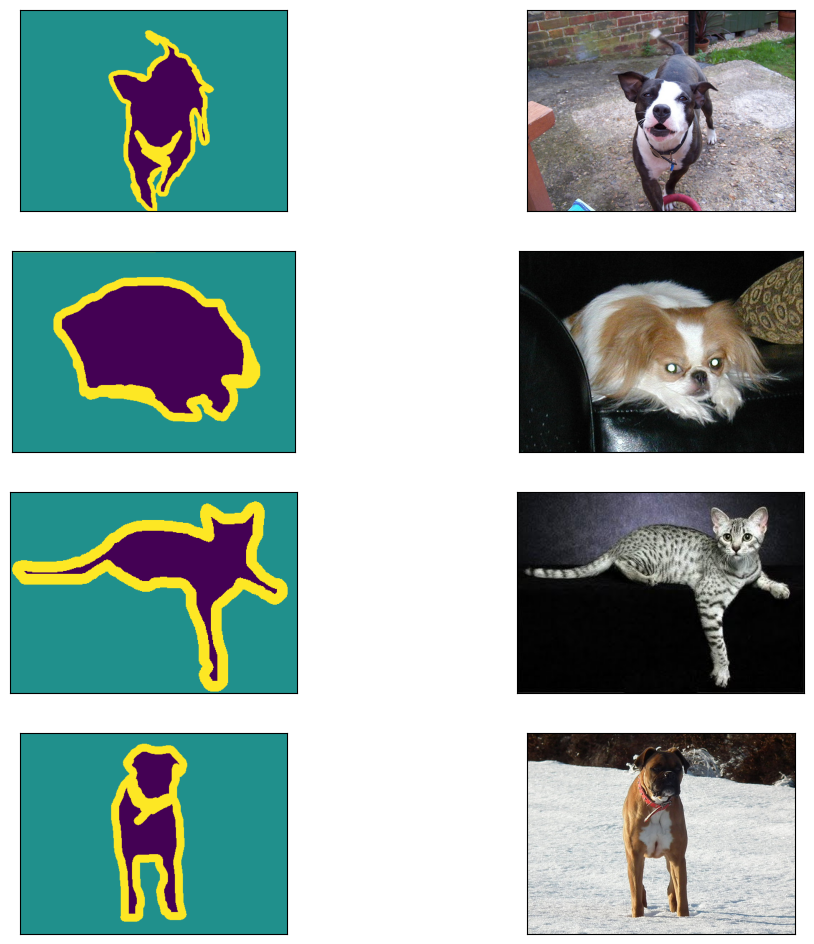

In [6]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [7]:
img = Image.open(os.path.join(trimaps_dir, maps[0]))
print(np.unique(img))

[1 2 3]


# SageMaker Setup

In [13]:
# sagemaker.image_uris.retrieve()

In [8]:
bucket_name = 'shreyasmahimkar'

In [9]:
role = sagemaker.get_execution_role()

# training_image = get_image_uri(region_name = boto3.Session().region_name, repo_name = 'sematic-segmentation', repo_version='latest',)
training_image = sagemaker.image_uris.retrieve(framework = 'semantic-segmentation',region = boto3.Session().region_name, version='latest')
print(training_image)

[03/14/25 13:19:48] INFO     Found credentials from IAM Role:                                   ]8;id=250151;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=954203;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=630738;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=861214;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=658554;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=840756;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

811284229777.dkr.ecr.us-east-1.amazonaws.com/semantic-segmentation:1


In [10]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [11]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:26<00:00, 279.20it/s]


In [12]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [13]:
print(len(train_annots), len(train_images))

5448 5448


# Uploading Data to S3

In [16]:
sess = sagemaker.Session()
print('Starting upload')
s3_train_path = sess.upload_data(path='train', bucket=bucket_name, key_prefix='train')
print('Training images uploaded')
s3_train_annotation_path = sess.upload_data(path='train_annotation', bucket=bucket_name, key_prefix='train_annotation')
print('Training annotation uploaed')
s3_validation_path = sess.upload_data(path='validation', bucket=bucket_name, key_prefix='validation')
print('Validation images uploaded')
s3_validation_annotation_path = sess.upload_data(path='validation_annotation', bucket=bucket_name, key_prefix='validation_annotation')
print('Validation annotation images uploaded')


[03/14/25 13:22:08] INFO     Found credentials from IAM Role:                                   ]8;id=210087;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=4923;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Starting upload
Training images uploaded
Training annotation uploaed
Validation images uploaded
Validation annotation images uploaded


In [17]:
s3_validation_annotation_path

's3://shreyasmahimkar/validation_annotation'

# SageMaker Estimator

In [44]:
# ?sagemaker.estimator.Estimator

In [45]:
model = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    volume_size=100,
    max_runtime_in_seconds = 36000,
    input_mode='File',
    output_path='s3://shreyasmahimkar/output',
    sagemaker_session=sess
)

In [46]:
# model = sagemaker.estimator.Estimator(
#     training_image,
#     role=role,
#     training_instance_count=1,
#     training_instance_type='ml.p3.2xlarge',
#     training_volumne_size=100,
#     max_runtime_in_seconds = 36000,
#     input_mode='File',
#     output_path='s3://shreyasmahimkar/output',
#     sagemaker_session=sess
# )

# Hyperparameters

In [47]:
?model.set_hyperparameters

Signature: model.set_hyperparameters(**kwargs)
Docstring:
Sets the hyperparameter dictionary to use for training.

The hyperparameters are made accessible as a dict[str, str] to the
training code on SageMaker. For convenience, this accepts other types
for keys and values, but ``str()`` will be called to convert them before
training.

If a source directory is specified, this method escapes the dict argument as JSON,
and updates the private hyperparameter attribute.
File:      ~/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py
Type:      method

In [48]:
model.set_hyperparameters(
    backbone='resnet-50',
    algorithm='fcn',
    use_pretrained_model=True,
    crop_size=240,
    num_classes=4,
    # epoch=10,
    learning_rate=0.0001,
    optimizer='rmsprop',
    lr_scheduler='poly',
    mini_batch_size=16,
    validation_mini_batch_size=16,
    num_training_samples=len(train_images)
)

In [49]:
# ?model

# Data Channels

In [50]:

train_data = sagemaker.inputs.TrainingInput(s3_data=s3_train_path,distribution='FullyReplicated',content_type='image/jpeg',s3_data_type='S3Prefix')

validation_data = sagemaker.inputs.TrainingInput(s3_data=s3_validation_path,distribution='FullyReplicated',content_type='image/jpeg',s3_data_type='S3Prefix')

train_annotation_data = sagemaker.inputs.TrainingInput(s3_data=s3_train_annotation_path,distribution='FullyReplicated',content_type='image/png',s3_data_type='S3Prefix')

validation_annotation_data = sagemaker.inputs.TrainingInput(s3_data=s3_validation_annotation_path,distribution='FullyReplicated',content_type='image/png',s3_data_type='S3Prefix')

In [51]:
data_channel = {
    'train' : train_data,
    'validation' : validation_data,
    'train_annotation': train_annotation_data,
    'validation_annotation':validation_annotation_data
}

In [52]:
data_channel

{'train': <sagemaker.inputs.TrainingInput at 0x7ffa198eb8e0>,
 'validation': <sagemaker.inputs.TrainingInput at 0x7ffa1974b4f0>,
 'train_annotation': <sagemaker.inputs.TrainingInput at 0x7ffa1974a140>,
 'validation_annotation': <sagemaker.inputs.TrainingInput at 0x7ffa198eb580>}

# Model Training

In [53]:
?model.fit

Signature:
model.fit(
    inputs: Union[str, Dict, sagemaker.inputs.TrainingInput, sagemaker.inputs.FileSystemInput, NoneType] = None,
    wait: bool = True,
    logs: str = 'All',
    job_name: Optional[str] = None,
    experiment_config: Optional[Dict[str, str]] = None,
)
Docstring:
Train a model using the input training dataset.

The API calls the Amazon SageMaker CreateTrainingJob API to start
model training. The API uses configuration you provided to create the
estimator and the specified input training data to send the
CreatingTrainingJob request to Amazon SageMaker.

This is a synchronous operation. After the model training
successfully completes, you can call the ``deploy()`` method to host the
model using the Amazon SageMaker hosting services.

Args:
    inputs (str or dict or sagemaker.inputs.TrainingInput or
        sagemaker.inputs.FileSystemInput): Information about the training data.
        This can be one of four types:

        * (str) the S3 location where training da

In [54]:
model.fit(inputs=data_channel,logs=True)

[03/14/25 14:26:07] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=320966;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=939389;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=791457;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=296941;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             semantic-segmentation-2025-03-14-14-26-07-764                                         

2025-03-14 14:26:07 Starting - Starting the training job...
.....03-14 14:26:13 Pending - Training job waiting for capacity.
..25-03-14 14:27:15 Pending - Preparing the instances for training.
..25-03-14 14:27:48 Downloading - Downloading input data.
.......................nloading - Downloading the training image.
..Docker entrypoint called with argument(s): trainleted. Training in progress..
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Fri Mar 14 14:32:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usa

# Deploy Model

In [55]:
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print("Model Deployed")

[03/14/25 15:05:33] INFO     Creating model with name:                                              ]8;id=551041;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=561562;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\
                             semantic-segmentation-2025-03-14-15-05-33-358                                         

[03/14/25 15:05:34] INFO     Creating endpoint-config with name                                     ]8;id=214214;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=505987;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5889\5889]8;;\
                             semantic-segmentation-2025-03-14-15-05-33-358                                         

                    INFO     Creating endpoint with name                                            ]8;id=190308;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=531746;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4711\4711]8;;\
                             semantic-segmentation-2025-03-14-15-05-33-358                                         

-------------------!Model Deployed


# Predictions

In [56]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

1942


In [57]:
deployed_model.content_type = 'image/jpeg'
deployed_model.accept = 'image/png'

In [58]:
index = 2

image_path = os.path.join(image_dir, images[index])
# image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)

In [59]:
mask = np.array(Image.open(io.BytesIO(results)))

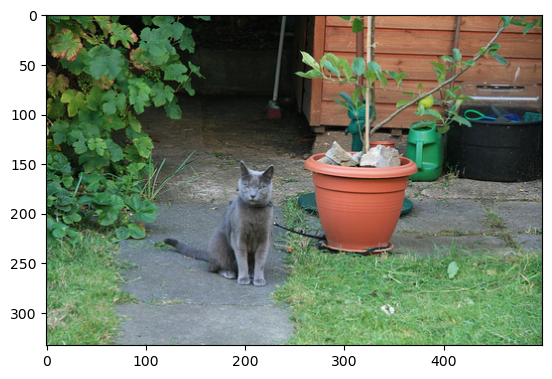

In [60]:
plt.imshow(plt.imread(image_path));

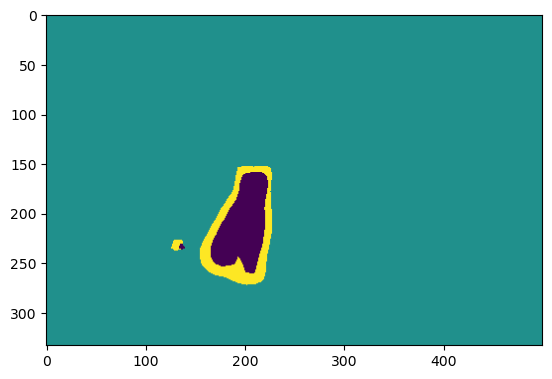

In [61]:
plt.imshow(mask);

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [62]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)

[03/14/25 15:31:58] WARNING  The endpoint attribute has been renamed in sagemaker>=2.            ]8;id=728563;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=711115;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     Deleting endpoint with name:                                           ]8;id=618052;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=684224;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4855\4855]8;;\
                             semantic-segmentation-2025-03-14-15-05-33-358                                         